# Multi-layer FNN on MNIST

This is MLP (784-X^W-10) on MNIST. SGD algorithm (lr=0.1) with 100 epoches.

 

In [2]:
import os, sys
import numpy as np
from matplotlib.pyplot import *
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import itertools


%matplotlib inline

In [23]:
""" Extract final stats from resman's diary file"""
def extract_num(lines0, is_reg=False):

    if is_reg:
        valid_loss_str     = lines0[-5]
        valid_accuracy_str = lines0[-6]
        train_loss_str     = lines0[-8]
        train_accuracy_str = lines0[-9]
        average_time_str   = lines0[-10]        
        run_time_str       = lines0[-11]   
        
    else: 
        valid_loss_str     = lines0[-6]
        valid_accuracy_str = lines0[-7]
        train_loss_str     = lines0[-10]
        train_accuracy_str = lines0[-11]
        average_time_str   = lines0[-12]        
        run_time_str       = lines0[-13]


    valid_loss     = float(valid_loss_str.split( )[-1])
    valid_accuracy = float(valid_accuracy_str.split( )[-1])
    train_loss     = float(train_loss_str.split( )[-1])
    train_accuracy = float(train_accuracy_str.split( )[-1])
    run_time       = float(run_time_str.split( )[-1])
    
    return valid_loss, valid_accuracy, train_loss, train_accuracy, run_time

""" Extract number of total parameters for each net config from resman's diary file"""
def parse_num_params(lines0):
    line_str = ''.join(lines0)
    idx = line_str.find("Trainable params: ") # 19 for "Trainable params: "
    # print line_str[idx:idx+29+20] 
    param_str = line_str[idx+18:idx+18+15] # 14 is the length of string "Total params: "

    param_num = param_str.split("\n")[0]
    return int(locale.atof(param_num))

#### Extract results from diary file

    1. Number of params
    2. Loss/Accuarcy for training/testing
    3. Runing time

In [24]:
def extract_dim_reward(results_dir, is_reg):
    # returns:
    # 
    # depth = [1,2,3,4,5]
    # width = [50,100,200,400]
    # dim   = [0,10,50,100,200,300,350,375,400,425,450,475,500,525,550,575,600,625,650,675,700,725,750,775,800,850,900,1000,1250,1500]
    # depth = [2]
    # width = [400]
    # dim = [1750,2000,2250,2500,3000,4000,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000,12500,15000,17500,20000,22500,25000]

    ########## 1. filename list of diary ########################
    diary_names = []
    for subdir, dirs, files in os.walk(results_dir):
        for file in files:
            if file == 'diary':
                fname = os.path.join(subdir, file)
                diary_names.append(fname)

    # print diary_names


    depth, width, dim = [], [], []
    for f in diary_names:
        # print f
        tmp_str = f.split('/')[-2]
        W = int(tmp_str.split('_')[-1])
        L = int(tmp_str.split('_')[-2])
        d = int(tmp_str.split('_')[-3])

        # if d not in dim:
        depth.append(L)
        width.append(W)
        dim.append(d)

    depth = list(set(depth)) 
    width = list(set(width))  
    dim = list(set(dim))    
    dim = sorted(dim)  

    # print "#L:" + str(len(depth)) + "#W:" + str(len(width)) + "#d:" + str(len(dim))

    ########## 2. Construct stats (width, depth, dim) ##########
    # acc_test_all : Tensor (width, depth, dim)
    # num_param_all: Tensor (width, depth)
    # acc_solved_all:  Tensor (width, depth)
    # dim_solved_all:  Tensor (width, depth)
    ############################################################
    nw, nd, nn= len(width), len(depth), len(dim)

    acc_test_all  = np.zeros((len(width), len(depth), len(dim)))
    num_param_all = np.zeros((len(width), len(depth)))
    acc_solved_all = np.zeros((len(width), len(depth)))
    dim_solved_all = np.zeros((len(width), len(depth)))

    mode = 1         # {0: test loss, 1: test acc}
    error_files = [] #  record the error file

    # 2.1 construct acc_test_all and num_param_all
    for id_w in range(len(width)):
        w = width[id_w]
        for id_ll in range(len(depth)):
            ll = depth[id_ll]
            for id_d in range(len(dim)):
                d = dim[id_d]

                # 2.1.1 Read the results, 
                for f in diary_names:
                    if '_'+str(d)+'_'+str(ll)+'_'+str(w)+'/' in f:
                        # print "%d is in" % d + f

                        with open(f,'r') as ff:
                            lines0 = ff.readlines()
                            try:
                                R = extract_num(lines0, is_reg)
                                R = np.array(R)
                                # print R
                                if d==0:
                                    num_param_all[id_w,id_ll]=parse_num_params(lines0) 

                            except ValueError:
                                error_files.append((w,ll,d))
                                R = np.zeros(5)
                                print "Error. Can not read config: depth %d, width %d and dim %d." % (ll, w, d) 
                                # break


                # 2.1.2 Assign the results
                r = R[mode]  
                # print "#w:" + str(id_w) + "#l:" + str(id_ll) + "#d:" + str(id_d) + ", acc:" + str(r)
                acc_test_all[id_w,id_ll,id_d]=r

    
    print acc_test_all.shape                
    return dim, acc_test_all, num_param_all                    

    # 2.2 construct acc_solved_all and dim_solved_all           
#     for id_w in range(len(width)):
#         w = width[id_w]
#         for id_ll in range(len(depth)):
#             ll = depth[id_ll]
#             for id_d in range(len(dim)):
#                 d = dim[id_d]

#                 r = acc_test_all[id_w,id_ll,id_d]
#                 if d==0:
#                     test_acc_bl = r     # 1.0     
#                     # print "Acc goal is: " + str(test_acc_sl) + " for network with depth " + str(ll) + " width "+ str(w)
#                 else:
#                     test_acc = r
#                     if test_acc>test_acc_bl*0.9:
#                         acc_solved_all[id_w,id_ll]=test_acc
#                         dim_solved_all[id_w,id_ll]=d
#                         # print "Intrinsic dim is: " + str(d) + " for network with depth " + str(ll) + " width "+ str(w)
#                         # print "\n"
#                         break

#     ########## 3. Construct Tensors for Analysis (width, depth, dim) ##########                    
#     acc_base  = acc_test_all[:,:,0]
#     acc_solve = acc_base*0.9


    

In [28]:
results_dir = '../results/fnn_mist_2_400_high_d'   
dim_h, acc_test_h, num_param_h = extract_dim_reward(results_dir, False)
subspace_h2 =  np.array([ (int(dim_h[i]), acc_test_h[:,:,i]) for i in range(len(dim_h)) ])

print ','.join(['[%i, %s]' % (subspace_h2[n,0], subspace_h2[n,1]) for n in xrange(len(subspace_h2))])

results_dir = '../results/fnn_mist_3_400_high_d'   
dim_h, acc_test_h, num_param_h = extract_dim_reward(results_dir, False)
subspace_h3 =  np.array([ (int(dim_h[i]), acc_test_h[:,:,i]) for i in range(len(dim_h)) ])

print ','.join(['[%i, %s]' % (subspace_h3[n,0], subspace_h3[n,1]) for n in xrange(len(subspace_h3))])


(1, 1, 23)
[1750, 0.9219],[2000, 0.9199],[2250, 0.9263],[2500, 0.9295],[3000, 0.931],[4000, 0.9351],[5000, 0.9443],[5500, 0.9471],[6000, 0.9503],[6500, 0.9505],[7000, 0.9508],[7500, 0.9518],[8000, 0.954],[8500, 0.9556],[9000, 0.9574],[9500, 0.9592],[10000, 0.9567],[12500, 0.9657],[15000, 0.9685],[17500, 0.97],[20000, 0.97],[22500, 0.9722],[25000, 0.972]
(1, 1, 37)
[1750, 0.9278],[2000, 0.9283],[2250, 0.9334],[2500, 0.9339],[3000, 0.9406],[3500, 0.9456],[4000, 0.9441],[4500, 0.9486],[5000, 0.9494],[5500, 0.9535],[6000, 0.9549],[6500, 0.9544],[7000, 0.9581],[7500, 0.9584],[8000, 0.9572],[8500, 0.9591],[9000, 0.9599],[9500, 0.9607],[10000, 0.963],[11000, 0.9667],[12000, 0.9641],[12500, 0.9649],[13000, 0.9685],[14000, 0.9666],[15000, 0.9675],[16000, 0.9698],[17000, 0.9701],[17500, 0.972],[18000, 0.9683],[19000, 0.9704],[20000, 0.9719],[21000, 0.9717],[22000, 0.9721],[22500, 0.9719],[23000, 0.9733],[24000, 0.9694],[25000, 0.9727]


In [26]:
results_dir = '../results/fnn_mnist_l2_adam_relu'  
dim, acc_test_all, num_param_all = extract_dim_reward(results_dir, True)


dim3 = np.repeat(dim, 4*5, axis=0).reshape([4, 5, len(dim)],order='F')
acc_test_all_d1 =  acc_test_all[:,:,1:].reshape((len(dim)-1)*4*5)
dim_d1 =  dim3[:,:,1:].reshape((len(dim)-1)*4*5)
subspace =  np.array([ (int(dim_d1[i]), acc_test_all_d1[i]) for i in range(len(dim_d1)) ])


print ','.join(['[%i, %s]' % (subspace[n,0], subspace[n,1]) for n in xrange(len(subspace))])

# print acc_test_all.shape

(4, 5, 30)
[10, 0.1637],[50, 0.4549],[100, 0.6083],[200, 0.7467],[300, 0.8154],[350, 0.8429],[375, 0.8341],[400, 0.8627],[425, 0.8576],[450, 0.868],[475, 0.8605],[500, 0.867],[525, 0.8727],[550, 0.8742],[575, 0.8855],[600, 0.8768],[625, 0.8903],[650, 0.8987],[675, 0.8902],[700, 0.8946],[725, 0.8961],[750, 0.8959],[775, 0.9017],[800, 0.9037],[850, 0.9046],[900, 0.9093],[1000, 0.9096],[1250, 0.9171],[1500, 0.927],[10, 0.2023],[50, 0.4345],[100, 0.6124],[200, 0.7551],[300, 0.8189],[350, 0.8347],[375, 0.8565],[400, 0.8516],[425, 0.8596],[450, 0.8578],[475, 0.8621],[500, 0.8693],[525, 0.8803],[550, 0.8787],[575, 0.8789],[600, 0.886],[625, 0.8935],[650, 0.8889],[675, 0.892],[700, 0.8932],[725, 0.901],[750, 0.9001],[775, 0.8966],[800, 0.9004],[850, 0.9081],[900, 0.9104],[1000, 0.9163],[1250, 0.9276],[1500, 0.9302],[10, 0.1443],[50, 0.4516],[100, 0.5923],[200, 0.7614],[300, 0.8117],[350, 0.8318],[375, 0.8515],[400, 0.8562],[425, 0.8574],[450, 0.8555],[475, 0.8661],[500, 0.8723],[525, 0.8723],[

In [8]:
print dim
print acc_test_all.shape
print num_param_h.shape

print "# Parmas"
print num_param_all

# print "Cross-line results"
# print acc_solved_all

# print "Cross-line Dim"
# print dim_solved_all

# print "Dim %d results" % dim[0]
# print acc_test_all[:,:,0]

[0, 10, 50, 100, 200, 300, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 850, 900, 1000, 1250, 1500]
(4, 5, 30)
(1, 1)
# Parmas
[[ 159010.  199210.  239410.  279610.  319810.]
 [ 318010.  478410.  638810.  799210.  959610.]
 [  39760.   42310.   44860.   47410.   49960.]
 [  79510.   89610.   99710.  109810.  119910.]]


#### List the config of depth and width, which yields errors in training

In [10]:
print "Shape of accuracy tensor: " + str(acc_test_all.shape)



print subspace.shape

Shape of accuracy tensor: (4, 5, 30)
(580, 2)


-------------------------

#### Check the accuracy of specific depth and width, along different dim

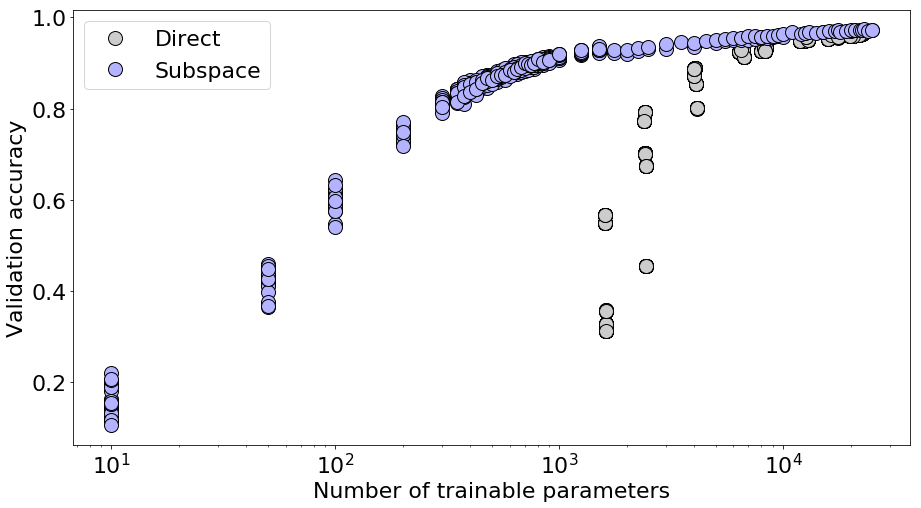

In [11]:
def figsize(width,height):
    rcParams['figure.figsize'] = (width,height)
    
font = {'size'   : 22}
matplotlib.rc('font', **font)

figsize(15, 8)

smallnets = np.array([
[12415, 0.948],[21185, 0.9611],[22485, 0.9644],[7960, 0.9257],[7960, 0.9257],[12895, 0.9511],[7960, 0.9257],[19885, 0.9588],[4105, 0.8014],[6442, 0.9242],[7960, 0.9257],[4075, 0.8532],[6586, 0.9286],[1612, 0.3131],[2443, 0.4556],[2395, 0.7732],[6586, 0.9286],[1612, 0.3132],[12415, 0.948],[4015, 0.8704],[2431, 0.6732],[17590, 0.9564],[4105, 0.8012],[12655, 0.9566],[12415, 0.948],[2419, 0.7016],[8400, 0.9326],[7960, 0.9257],[16330, 0.9605],[1612, 0.3131],[6370, 0.9233],[2431, 0.6732],[1624, 0.3284],[1618, 0.3559],[6658, 0.9124],[4105, 0.8014],[21185, 0.9608],[1600, 0.5657],[2431, 0.6731],[4015, 0.8704],[17170, 0.9601],[1612, 0.3132],[17590, 0.9566],[6586, 0.9289],[15910, 0.9522],[8400, 0.9328],[1606, 0.5484],[12175, 0.9509],[12175, 0.9509],[2395, 0.7732],[2395, 0.7732],[2395, 0.7732],[22485, 0.9658],[7960, 0.9257],[1606, 0.5484],[12415, 0.9478],[2443, 0.4558],[1600, 0.5657],[7960, 0.9257],[12415, 0.948],[2419, 0.7016],[21835, 0.9622],[4015, 0.8704],[2443, 0.4556],[2395, 0.7732],[8180, 0.9325],[3985, 0.8871],[19885, 0.9588],[21835, 0.9622],[20535, 0.9595],[16750, 0.96],[1606, 0.5484],[12655, 0.9566],[1618, 0.3568],[1612, 0.3132],[16330, 0.9605],[1624, 0.3284],[1600, 0.5657],[7960, 0.9257],[12175, 0.9509],[2443, 0.4557],[2443, 0.4556],[4075, 0.8532],[4015, 0.8704],[4045, 0.8899],[4045, 0.8899],[17170, 0.9601],[21835, 0.9623],[16330, 0.9605],[8400, 0.9333],[17170, 0.961],[16750, 0.96],[6370, 0.9233],[16750, 0.9602],[1624, 0.3284],[17590, 0.9566],[7960, 0.9257],[8070, 0.931],[8400, 0.9328],[2419, 0.7013],[19885, 0.9588],[15910, 0.9522],[6658, 0.9124],[16750, 0.96],[6370, 0.9233],[17590, 0.9557],[8290, 0.9271],[8400, 0.9329],[8290, 0.9271],[15910, 0.9522],[7960, 0.9257],[12175, 0.9509],[3985, 0.8871],[3985, 0.8871],[16330, 0.9605],[8290, 0.9271],[19885, 0.9588],[11935, 0.947],[7960, 0.9257],[21835, 0.9626],[17170, 0.9611],[6586, 0.9289],[8180, 0.9325],[1600, 0.5657],[8070, 0.931],[17590, 0.9564],[6514, 0.9278],[4075, 0.8532],[6658, 0.9123],[12655, 0.9567],[8290, 0.9271],[8400, 0.9328],[8290, 0.9277],[2419, 0.7013],[1612, 0.3132],[4105, 0.8013],[17590, 0.9565],[1606, 0.5484],[20535, 0.9595],[21185, 0.9612],[12895, 0.9511],[8180, 0.9325],[4105, 0.8018],[2419, 0.7013],[12415, 0.948],[12655, 0.9566],[16330, 0.9605],[22485, 0.9646],[6658, 0.9124],[2419, 0.7016],[1600, 0.5657],[1618, 0.3563],[6514, 0.9281],[2407, 0.7933],[8290, 0.9271],[12415, 0.948],[20535, 0.9595],[12415, 0.948],[2419, 0.7013],[12175, 0.9509],[8290, 0.9271],[21185, 0.9608],[4075, 0.853],[12175, 0.9509],[8180, 0.9325],[2419, 0.7016],[2407, 0.7933],[1624, 0.3285],[12415, 0.948],[2395, 0.7732],[2407, 0.7933],[2419, 0.7013],[12655, 0.9563],[16330, 0.9605],[8070, 0.931],[12895, 0.9511],[4045, 0.8895],[22485, 0.9641],[6514, 0.9278],[4015, 0.8704],[21835, 0.9626],[16330, 0.9605],[4105, 0.8018],[4105, 0.8016],[2395, 0.7732],[22485, 0.9639],[1612, 0.3132],[8070, 0.931],[8400, 0.9328],[8400, 0.9328],[15910, 0.9522],[12655, 0.9567],[6514, 0.9278],[4075, 0.8532],[12415, 0.948],[4045, 0.8894],[12655, 0.9565],[21185, 0.9607],[1624, 0.3284],[6370, 0.9233],[1618, 0.3567],[17170, 0.9611],[4105, 0.8016],[2443, 0.4556],[6658, 0.9124],[2419, 0.7013],[1612, 0.3132],[17590, 0.9566],[4105, 0.8016],[12895, 0.9511],[6442, 0.9242],[1618, 0.3568],[1624, 0.3284],[12895, 0.9511],[1606, 0.5484],[15910, 0.9522],[12415, 0.948],[21185, 0.9608],[21835, 0.9622],[3985, 0.8871],[12655, 0.9565],[3985, 0.8871],[16750, 0.96],[4015, 0.8704],[16330, 0.9605],[16330, 0.9606],[4015, 0.8704],[21835, 0.9622],[1618, 0.3568],[12895, 0.9511],[21185, 0.9608],[6370, 0.9233],[22485, 0.9644],[2395, 0.7732],[16750, 0.96],[22485, 0.9639],[3985, 0.8871],[7960, 0.9257],[8070, 0.931],[12415, 0.948],[16750, 0.96],[12175, 0.9509],[22485, 0.9645],[15910, 0.9522],[17170, 0.9611],[2407, 0.7933],[2419, 0.7016],[1624, 0.3284],[8290, 0.9271],[12175, 0.9509],[2443, 0.4556],[2419, 0.7016],[2443, 0.4556],[4045, 0.8899],[12895, 0.951],[2395, 0.7732],[4045, 0.8899],[16750, 0.96],[15910, 0.9522],[2443, 0.4556],[1612, 0.3132],[6514, 0.9281],[12175, 0.9509],[12655, 0.9563],[21835, 0.9623],[7960, 0.9257],[17590, 0.9565],[16750, 0.96],[21835, 0.9622],[2443, 0.4558],[20535, 0.9595],[8070, 0.931],[3985, 0.8871],[16750, 0.9602],[12415, 0.948],[8290, 0.9271],[1600, 0.5657],[1612, 0.3132],[2407, 0.7933],[21185, 0.9609],[6658, 0.9124],[12895, 0.9511],[2407, 0.7933],[1618, 0.3567],[1606, 0.5484],[1612, 0.3132],[4075, 0.8532],[16330, 0.9605],[12655, 0.9565],[19885, 0.9588],[17590, 0.9565],[4105, 0.8014],[4015, 0.8704],[4045, 0.8899],[4015, 0.8704],[6586, 0.929],[8070, 0.931],[6586, 0.929],[8180, 0.9325],[1624, 0.3284],[17590, 0.9566],[1606, 0.5484],[21835, 0.9622],[4105, 0.8017],[4015, 0.8704],[2395, 0.7732],[16330, 0.9605],[6658, 0.9124],[11935, 0.947],[1612, 0.3132],[8180, 0.9325],[4075, 0.853],[21835, 0.9622],[3985, 0.8871],[1624, 0.3285],[11935, 0.947],[8400, 0.933],[11935, 0.947],[6514, 0.928],[16330, 0.9605],[4015, 0.8704],[6370, 0.9233],[12175, 0.9509],[11935, 0.947],[20535, 0.9595],[16330, 0.9605],[8180, 0.9325],[2443, 0.4557],[22485, 0.9646],[2443, 0.4556],[17590, 0.9566],[4045, 0.8894],[12415, 0.9478],[15910, 0.9522],[6370, 0.9233],[2431, 0.6732],[8400, 0.9331],[6370, 0.9233],[17590, 0.9568],[21835, 0.9622],[1612, 0.3131],[11935, 0.947],[3985, 0.8871],[11935, 0.947],[12415, 0.948],[17170, 0.961],[2395, 0.7732],[8070, 0.931],[6586, 0.9286],[2395, 0.7732],[21835, 0.9623],[3985, 0.8871],[16330, 0.9605],[22485, 0.9656],[1618, 0.3565],[17170, 0.9609],[12655, 0.9566],[1624, 0.3284],[4015, 0.8704],[19885, 0.9588],[7960, 0.9257],[17170, 0.9601],[21835, 0.9622],[8400, 0.933],[4105, 0.8003],[4075, 0.8531],[1618, 0.3561],[7960, 0.9257],[4105, 0.8016],[15910, 0.9522],[15910, 0.9522],[8070, 0.931],[2395, 0.7732],[2431, 0.6758],[12655, 0.9565],[12895, 0.9511],[17590, 0.9564],[21835, 0.9623],[21835, 0.9622],[2419, 0.7016],[6586, 0.9289],[2407, 0.7933],[11935, 0.947],[17170, 0.9612],[6514, 0.9278],[12895, 0.9511],[3985, 0.8871],[17590, 0.9564],[1618, 0.3567],[4045, 0.8899],[2431, 0.6732],[8290, 0.9271],[12415, 0.948],[17170, 0.9609],[2419, 0.7016],[17590, 0.9566],[6514, 0.9278],[21835, 0.9622],[12655, 0.9566],[16750, 0.9602],[4075, 0.853],[2443, 0.4558],[8400, 0.9328],[19885, 0.9588],[21835, 0.9623],[2443, 0.4556],[12655, 0.9566],[17590, 0.9576],[8400, 0.933],[12895, 0.9511],[2443, 0.4555],[1606, 0.5484],[17590, 0.9564],[1624, 0.3284],[21835, 0.9622],[1612, 0.3132],[1606, 0.5484],[1618, 0.3561],[21185, 0.9608],[8070, 0.931],[19885, 0.9588],[12175, 0.9509],[16750, 0.9602],[15910, 0.9522],[4075, 0.853],[3985, 0.8871],[1600, 0.5657],[12415, 0.9478],[17590, 0.9566],[22485, 0.9645],[8400, 0.9328],[6442, 0.9242],[17590, 0.9563],[6442, 0.9242],[19885, 0.9588],[22485, 0.9649],[8290, 0.9271],[4015, 0.8704],[20535, 0.9595],[21185, 0.9608],[4045, 0.8895],[6370, 0.9233],[1624, 0.3284],[8070, 0.931],[2419, 0.7016],[22485, 0.9644],[6442, 0.9242],[6514, 0.9278],[12655, 0.9566],[8290, 0.9271],[12415, 0.948],[4105, 0.8015],[20535, 0.9595],[1600, 0.5657],[2443, 0.4556],[2419, 0.7016],[6658, 0.9124],[8400, 0.9328],[12655, 0.9567],[8400, 0.9326],[22485, 0.964],[2419, 0.7016],[1600, 0.5657],[21835, 0.9622],[17170, 0.961],[1624, 0.3285],[21835, 0.9622],[2407, 0.7933],[12655, 0.9564],[21185, 0.9609],[1606, 0.5484],[1606, 0.5484],[17590, 0.9566],[22485, 0.9651],[21835, 0.9622],[2443, 0.4556],[4045, 0.8895],[6658, 0.9126],[22485, 0.9649],[3985, 0.8871],[2443, 0.4556],[6658, 0.9124],[11935, 0.947],[1606, 0.5484],[11935, 0.947],[22485, 0.9638],[2407, 0.7933],[12415, 0.948],[12655, 0.9565],[1606, 0.5484],[19885, 0.9588],[4075, 0.853],[6586, 0.929],[8400, 0.9328],[4105, 0.8014],[4045, 0.8899],[21185, 0.9609],[2431, 0.6732],[16330, 0.9605],[12895, 0.9511],[6514, 0.9278],[2395, 0.7732],[8290, 0.9277],[8400, 0.9326],[6586, 0.929],[16750, 0.9602],[17590, 0.9564],[6658, 0.9124],[12175, 0.9509],[6514, 0.9278],[1624, 0.3284],[17590, 0.9566],[1600, 0.5657],[4075, 0.8532],[4075, 0.8532],[4105, 0.8009],[6514, 0.9278],[12655, 0.9566],[2395, 0.7732],[1600, 0.5657],[1618, 0.3569],[20535, 0.9594],[3985, 0.8871],[1618, 0.3564],[3985, 0.8871],[4045, 0.8894],[1606, 0.5484],[2419, 0.7016],[11935, 0.947],[4015, 0.8704],[15910, 0.9522],[3985, 0.8871],[20535, 0.9595],[20535, 0.9595],[1618, 0.3567],[4075, 0.8532],[4075, 0.8532],[12415, 0.948],[6658, 0.9124],[11935, 0.947],[8070, 0.931],[16330, 0.9605],[4105, 0.8017],[4015, 0.8704],[16330, 0.9605],[1600, 0.5657],[4105, 0.8018],[12175, 0.9509],[2395, 0.7732],[8290, 0.9271],[8290, 0.9271],[8400, 0.9328],[19885, 0.9588],[17590, 0.9566],[17170, 0.9601],[16750, 0.9602],[2443, 0.4558],[3985, 0.8871],[3985, 0.8871],[21835, 0.9622],[19885, 0.9588],[2419, 0.7013],[12415, 0.948],[8290, 0.9271],[1600, 0.5657],[8070, 0.931],[6586, 0.9289],[6658, 0.9126],[6442, 0.9242],[12895, 0.9511],[12655, 0.9564],[12415, 0.948],[6514, 0.9277],[12175, 0.9509],[1606, 0.5484],[6514, 0.9278],[2419, 0.7013],[6442, 0.9242],[4045, 0.8894],[6514, 0.9278],[1612, 0.3132],[12415, 0.948],[8070, 0.931],[15910, 0.9522],[19885, 0.9588],[4105, 0.8017],[8180, 0.9325],[19885, 0.9588],[17170, 0.9609],[4105, 0.8014],[2443, 0.4556],[4015, 0.8704],[12655, 0.9561],[22485, 0.9646],[6586, 0.9286],[8180, 0.9325],[6514, 0.9278],[12895, 0.9511],[1606, 0.5484],[19885, 0.9588],[8400, 0.9328],[1618, 0.3566],[7960, 0.9257],[2443, 0.4556],[21835, 0.9625],[8180, 0.9325],[20535, 0.9595],[19885, 0.9588],[3985, 0.8871],[8070, 0.931],[16330, 0.9605],[21835, 0.9622],[2407, 0.7933],[8070, 0.931],[1624, 0.328],[6514, 0.9278],[19885, 0.9588],[17170, 0.961],[16330, 0.9605],[2395, 0.7732],[17170, 0.9612],[12175, 0.9509],[22485, 0.965],[1606, 0.5484],[4105, 0.8016],[17590, 0.9566],[6586, 0.9289],[12655, 0.9561],[7960, 0.9257],[6370, 0.9233],[8400, 0.9328],[6442, 0.9242],[7960, 0.9257],[1624, 0.3285],[1606, 0.5484],[1612, 0.3132],[16750, 0.9602],[1618, 0.3571],[2419, 0.7013],[12175, 0.9509],[12175, 0.9509],[22485, 0.9648],[2395, 0.7732],[6586, 0.9286],[4045, 0.8895],[8290, 0.9271],[11935, 0.947],[4105, 0.8016],[8290, 0.9271],[2431, 0.6732],[17590, 0.9564],[16330, 0.9605],[6514, 0.9278],[6514, 0.9278],[6442, 0.9242],[16750, 0.9602],[6442, 0.9242],[8400, 0.9345],[12655, 0.9566],[20535, 0.9594],[4105, 0.8014],[20535, 0.9595],[21185, 0.9607],[16750, 0.9602],[1618, 0.357],[12655, 0.9567],[16750, 0.96],[1600, 0.5657],[15910, 0.9522],[16330, 0.9605],[1600, 0.5657],[1624, 0.3285],[16750, 0.9602],[1612, 0.3132],[8290, 0.9271],[6658, 0.9124],[19885, 0.9588],[19885, 0.9588],[19885, 0.9588],[2419, 0.7013],[8400, 0.9326],[12895, 0.9511],[12175, 0.9509],[2431, 0.6731],[11935, 0.947],[2395, 0.7732],[6586, 0.929],[1606, 0.5484],[8400, 0.9328],[3985, 0.8871],[6442, 0.9242],[4105, 0.7998],[8400, 0.9328],[1612, 0.3132],[3985, 0.8871],[6370, 0.9233],[1606, 0.5484],[15910, 0.9522],[21835, 0.9623],[1624, 0.3284],[8180, 0.9325],[2431, 0.6732],[6658, 0.9124],[4015, 0.8704],[6586, 0.9289],[12175, 0.9509],[6658, 0.9124],[1624, 0.3285],[11935, 0.947],[21835, 0.9622],[6586, 0.9289],[6658, 0.9124],[1612, 0.3132],[1606, 0.5484],[8400, 0.9326],[2419, 0.7013],[6514, 0.9278],[1606, 0.5484],[6586, 0.9288],[19885, 0.9588],[2395, 0.7732],[17170, 0.9611],[20535, 0.9595],[11935, 0.947],[12415, 0.948],[1624, 0.3285],[11935, 0.947],[6370, 0.9233],[22485, 0.9645],[1618, 0.3563],[15910, 0.9522],[1618, 0.3572],[4045, 0.8899],[6586, 0.9289],[12655, 0.9565],[2443, 0.4558],[2443, 0.4557],[2443, 0.4556],[4075, 0.853],[8180, 0.9325],[8400, 0.933],[1624, 0.3284],[12895, 0.9511],[21185, 0.9609],[7960, 0.9257],[6370, 0.9233],[16330, 0.9606],[6370, 0.9233],[6586, 0.9289],[20535, 0.9591],[12655, 0.9567],[3985, 0.8871],[4045, 0.8895],[4015, 0.8704],[4105, 0.8018],[4075, 0.853],[2443, 0.4558],[2407, 0.7933],[1624, 0.3284],[12895, 0.9511],[7960, 0.9257],[12175, 0.9509],[6370, 0.9233],[2395, 0.7732],[21835, 0.9622],[2395, 0.7732],[4105, 0.8009],[2443, 0.4556],[19885, 0.9588],[1606, 0.5484],[4105, 0.8015],[6514, 0.9278],[21835, 0.9627],[21185, 0.9608],[21835, 0.9622],[1612, 0.3131],[1612, 0.3132],[8180, 0.9324],[7960, 0.9257],[2419, 0.7016],[6658, 0.9124],[4045, 0.8895],[12175, 0.9509],[17170, 0.9601],[12175, 0.9509],[12175, 0.9509],[15910, 0.9522],[16330, 0.9605],[4015, 0.8704],[6442, 0.9242],[8070, 0.931],[12895, 0.9511],[7960, 0.9257],[3985, 0.8871],[6586, 0.9288],[12895, 0.9511],[6442, 0.9242],[17590, 0.9574],[1618, 0.3578],[12655, 0.9561],[8070, 0.931],[2407, 0.7933],[8290, 0.9271],[16330, 0.9605],[6586, 0.9289],[12895, 0.9511],[21835, 0.9623],[1600, 0.5657],[1612, 0.3132],[16330, 0.9605],[12415, 0.948],[3985, 0.8871],[22485, 0.9652],[2395, 0.7732],[8290, 0.9271],[8070, 0.931],[16330, 0.9605],[2431, 0.6732],[4105, 0.8018],[8400, 0.9328],[12175, 0.9509],[6586, 0.9289],[17590, 0.9566],[4105, 0.8016],[2407, 0.7933],[11935, 0.947],[16330, 0.9605],[19885, 0.9588],[6514, 0.9278],[2443, 0.4556],[6586, 0.9289],[16750, 0.9601],[12655, 0.9567],[6514, 0.9278],[16750, 0.96],[2407, 0.7933],[3985, 0.8871],[17170, 0.9612],[4105, 0.8016],[22485, 0.9653],[6586, 0.9289],[19885, 0.9588],[1624, 0.3285],[11935, 0.947],[16750, 0.96],[16330, 0.9606],[21185, 0.9608],[2395, 0.7732],[21835, 0.9622],[6514, 0.9278],[8400, 0.933],[2431, 0.6731],[16750, 0.96],[4105, 0.8015],[1624, 0.3284],[21835, 0.9625],[12895, 0.9511],[3985, 0.8871],[1624, 0.3284],[8180, 0.9325],[8290, 0.9271],[1606, 0.5484],[17590, 0.9564],[12655, 0.9566],[4075, 0.853],[8400, 0.9328],[12655, 0.9562],[15910, 0.9522],[4015, 0.8704],[1606, 0.5484],[1618, 0.3565],[12655, 0.9564],[6442, 0.9242],[12895, 0.9511],[2419, 0.7013],[6658, 0.9124],[16750, 0.96],[8070, 0.931],[2407, 0.7933],[17590, 0.9564],[8400, 0.9329],[8180, 0.9325],[6442, 0.9242],[6658, 0.9124],[12415, 0.948],[1600, 0.5657],[8400, 0.9328],[1612, 0.3132],[4015, 0.8704],[1624, 0.3285],[16330, 0.9605],[11935, 0.947],[2443, 0.4556],[2443, 0.4558],[16750, 0.9601],[4105, 0.8015],[3985, 0.8871],[2443, 0.4557],[4045, 0.8894],[12655, 0.9565],[16750, 0.9602],[21835, 0.9622],[17590, 0.9566],[3985, 0.8871],[1606, 0.5484],[6586, 0.9289],[2431, 0.6732],[22485, 0.965],[12175, 0.9509],[21185, 0.9608],[6442, 0.9242],[16330, 0.9605],[12175, 0.9509],[6658, 0.9126],[6370, 0.9233],[19885, 0.9588],[1612, 0.3132],[22485, 0.9645],[2419, 0.7016],[12655, 0.9566],[17170, 0.9601],[22485, 0.965],[4105, 0.8016],[7960, 0.9257],[1618, 0.3559],[2443, 0.4557],[17170, 0.9601],[12175, 0.9509],[4105, 0.8015],[2395, 0.7732],[1618, 0.3555],[2419, 0.7013],[8180, 0.9325],[1624, 0.3284],[1612, 0.3132],[1606, 0.5484],[2395, 0.7732],[12415, 0.948],[2431, 0.6731],[1606, 0.5484],[12655, 0.9563],[6514, 0.9278],[15910, 0.9522],[2407, 0.7933],[12655, 0.9567],[6658, 0.9124],[12175, 0.9509],[1600, 0.5657],[4105, 0.8012],[1618, 0.3578],[2407, 0.7933],[6370, 0.9233],[12655, 0.9562],[1618, 0.3569],[15910, 0.9522],[6370, 0.9233],[2443, 0.4556],[1606, 0.5484],[19885, 0.9588],[2431, 0.6732],[22485, 0.965],[21835, 0.9623],[8400, 0.9328],[1624, 0.3284],[1618, 0.3566],[8180, 0.9325],[22485, 0.9638],[17170, 0.9609],[6514, 0.9278],[15910, 0.9522],[22485, 0.9645],[1612, 0.3131],[1606, 0.5484],[2419, 0.7013],[2407, 0.7933],[2431, 0.6731],[11935, 0.947],[21185, 0.961],[1600, 0.5657],[16330, 0.9605],[21185, 0.9608],[6658, 0.9124],[3985, 0.8871],[2431, 0.6732],[2395, 0.7732],[1600, 0.5657],[22485, 0.9636],[6514, 0.9278],[1618, 0.3569],[8290, 0.9271],[12895, 0.9511],[22485, 0.965],[2443, 0.4558],[12655, 0.9565],[17590, 0.9564],[21835, 0.9622],[8290, 0.9271],[12655, 0.9567],[20535, 0.9595],[19885, 0.9588],
])

semilogx(smallnets[:,0], smallnets[:,1], 'o', mfc=(.8,.8,.8), mec='k', ms=14, label='Direct')
semilogx(subspace[:,0], subspace[:,1], 'o', mfc=(.7,.7,1), mec='k', ms=14, label='Subspace')
semilogx(subspace_h2[:,0], subspace_h2[:,1], 'o', mfc=(.7,.7,1), mec='k', ms=14)
semilogx(subspace_h3[:,0], subspace_h3[:,1], 'o', mfc=(.7,.7,1), mec='k', ms=14)
xlabel('Number of trainable parameters')
ylabel('Validation accuracy')
plt.legend()
# savefig('mnist_small_direct_log.png')
savefig('figs/mnist_trainable_cmp_log.pdf', bbox_inches='tight')

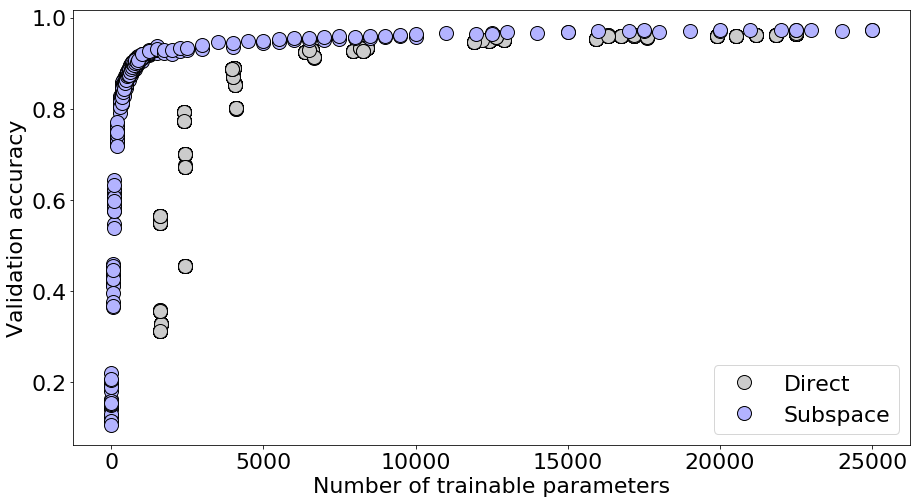

In [27]:
plot(smallnets[:,0], smallnets[:,1], 'o', mfc=(.8,.8,.8), mec='k', ms=14, label='Direct')
plot(subspace[:,0], subspace[:,1], 'o', mfc=(.7,.7,1), mec='k', ms=14, label='Subspace')
plot(subspace_h2[:,0], subspace_h2[:,1], 'o', mfc=(.7,.7,1), mec='k', ms=14)
plot(subspace_h3[:,0], subspace_h3[:,1], 'o', mfc=(.7,.7,1), mec='k', ms=14)
xlabel('Number of trainable parameters')
ylabel('Validation accuracy')
plt.legend()
# savefig('mnist_small_direct.png')
savefig('figs/mnist_trainable_cmp.pdf', bbox_inches='tight')

Reshape the tensor to 1D for plots

In [ ]:


fig_width = width*len(depth)
fig_depth = list(itertools.chain.from_iterable(itertools.repeat(x, len(width)) for x in depth))

print fig_width
print fig_depth
print num_param_all

print "Ratio of D: " + str(np.max(num_param_all[:])/(np.min(num_param_all[:])+.0))
print dim_solved_all
print "Ratio of D: " + str(np.max(dim_solved_all[:])/(np.min(dim_solved_all[:])+.0))

fig_params_1d = num_param_all.reshape(len(depth)*len(width),order='F')
dim_solved_all_1d = dim_solved_all.reshape(len(depth)*len(width),order='F')
acc_solved_all_1d = acc_solved_all.reshape(len(depth)*len(width),order='F')
print fig_params_1d
print dim_solved_all_1d

### Testing Accuracy wrt. Width, Depth and Dim

In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns

plt.figure(figsize=(20,5.0))

for i in range(acc_test_all.shape[2]):
    acc = acc_test_all[:,:,i].reshape(len(depth)*len(width),order='F')
    if i==0:
        plt.scatter(fig_params_1d, acc, s=(np.array(fig_width)**1.8)/100, c=fig_depth, edgecolors='k') 
        plt.scatter(fig_params_1d, 0.9*acc, marker="_", s=300, c='k', edgecolors='r') 
    else:
        plt.scatter(fig_params_1d, acc, s=(np.array(fig_width)**1.8)/100, c=fig_depth, facecolors='None', linewidth=np.array(dim[i])/300.0) 

        
ax = plt.gca()
plt.colorbar(label="Depth")

ax.set_xscale('log')
ax.grid(True)

ax.set_ylim(0.8, 1.0)
ax.set_xlim(0.3E4, 1.5E6)

plt.xlabel('# parameters')
plt.ylabel('# accuracy')

#make a legend:
pws = width
for pw in pws:
    plt.scatter([], [], s=(pw**1.8)/1000, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[0:], l[0:], labelspacing=1.2, title="layer width", borderpad=1, loc='best', bbox_to_anchor=(1.25, 1),
             frameon=True, framealpha=0.6, edgecolor="k", facecolor="w")

 
    

#### Testing Accuracy of Intrinsic dim for #parameters

In [ ]:
plt.figure(figsize=(20,5))


plt.scatter(fig_params_1d, acc_solved_all_1d, s=(np.array(fig_width)**2.0)/100, c=fig_depth, edgecolors='k') 

ax = plt.gca()
plt.colorbar(label="Depth")

ax.set_xscale('log')
ax.grid(True)

ax.set_ylim(0.0, 1.0)
ax.set_xlim(0.3E5, 1.5E6)


plt.xlabel('# parameters')
plt.ylabel('# accuracy')

#make a legend:
pws = width
for pw in pws:
    plt.scatter([], [], s=(pw**1.8)/100, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[0:], l[0:], labelspacing=1.2, title="layer width", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w")

#### Intrinsic dim for #parameters

In [ ]:
# plt.figure(figsize=(20,5))

fig, ax = subplots(figsize=(20,5) )

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

plt.scatter(fig_params_1d, dim_solved_all_1d, s=(np.array(fig_width)**2.0)/100, c=fig_depth, edgecolors='k') 

ax = plt.gca()
plt.colorbar(label="Depth")

ax.set_xscale('log')

ax.grid(True)
ax.set_ylim(400, 1000)

plt.ylabel('Intrinsic dimension $d_{int}$')
plt.xlabel('Number of parameters $D$')
ax.set_xlim(0.3E5, 1.5E6)

#make a legend:
pws = width
for pw in pws:
    plt.scatter([], [], s=(pw**1.8)/100, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[0:], l[0:], labelspacing=1.2, title="layer width", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w")

fig.savefig("figs/fnn_mnist_dim_global.pdf", bbox_inches='tight')

## Performance comparison with Baseline

In [ ]:
fig = plt.figure(figsize=(20,16))
fig.subplots_adjust(hspace=0.4)

acc_solved_all

for i in range(nw):
    for j in range(nd):
        id = i*nd+j+1
        ax = plt.subplot(nw, nd, id)

        plot(dim[1:], acc_test_all[i,j,1:], 'o', mec='b', mfc=(.8,.8,1), ms=10)
        plot(dim_solved_all[i,j], acc_solved_all[i,j], 'o', mec='b', mfc='b', ms=10)
        axhline(acc_test_all[i,j,0], ls='-', color='k')
        axhline(acc_test_all[i,j,0] * .9, ls=':', color='k')
        ax.set_xlabel('Subspace dim $d$')
        if j==0:
            ax.set_ylabel('Validation accuracy')
            
        ax.set_title('width %d, depth %d' %(width[i], depth[j]))
        plt.grid()
        ax.set_ylim([0.1,1.01])
        
fig.savefig("figs/fnn_mnist_all_configs.pdf", bbox_inches='tight')

In [ ]:
fig, ax = subplots(figsize=(5,4) )

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

acc_solved_all

i,j = 3,1 

print dim_solved_all[i,j]

id = i*nd+j+1
# ax = plt.subplot(nw, nd, id)

plot(dim[1:], acc_test_all[i,j,1:], 'o', mec='b', mfc=(.8,.8,1), ms=10)
plot(dim_solved_all[i,j], acc_solved_all[i,j], 'o', mec='b', mfc='b', ms=10)
axhline(acc_test_all[i,j,0], ls='-', color='k',label='baseline')
axhline(acc_test_all[i,j,0] * .9, ls=':', color='k',label='solved')
plt.legend()
ax.set_xlabel('Subspace dimension $d$')
ax.set_ylabel('Validation accuracy')

ax.set_title('width %d, depth %d' %(width[i], depth[j]))
plt.grid()
ax.set_ylim([0.1,1.01])
        
fig.savefig("figs/fnn_mnist_W"+str(width[i])+"_L"+str(depth[j])+"_configs.pdf", bbox_inches='tight')

In [ ]:
def extract_dim_reward_maxd(results_dir, is_reg):
    # returns:
    # 
    ########## 1. filename list of diary ########################
    diary_names = []
    for subdir, dirs, files in os.walk(results_dir):
        for file in files:
            if file == 'diary':
                fname = os.path.join(subdir, file)
                diary_names.append(fname)

    # print diary_names


    depth, width, dim = [], [], []
    for f in diary_names:
        # print f
        tmp_str = f.split('/')[-2]
        W = int(tmp_str.split('_')[-1])
        L = int(tmp_str.split('_')[-2])
        d = int(tmp_str.split('_')[-3])

        # if d not in dim:
        depth.append(L)
        width.append(W)
        dim.append(d)

    depth = list(set(depth)) 
    width = list(set(width))  
    dim = list(set(dim))    
    dim = sorted(dim)  

    print "#L:" + str(len(depth)) + "#W:" + str(len(width)) + "#d:" + str(len(dim))

    ########## 2. Construct stats (width, depth, dim) ##########
    # acc_test_all : Tensor (width, depth, dim)
    # num_param_all: Tensor (width, depth)
    # acc_solved_all:  Tensor (width, depth)
    # dim_solved_all:  Tensor (width, depth)
    ############################################################
    nw, nd, nn= len(width), len(depth), len(dim)

    acc_test_all  = np.zeros((len(width), len(depth), len(dim)))
    num_param_all = np.zeros((len(width), len(depth)))
    acc_solved_all = np.zeros((len(width), len(depth)))
    dim_solved_all = np.zeros((len(width), len(depth)))

    mode = 1         # {0: test loss, 1: test acc}
    error_files = [] #  record the error file

    # 2.1 construct acc_test_all and num_param_all
    for id_w in range(len(width)):
        w = width[id_w]
        for id_ll in range(len(depth)):
            ll = depth[id_ll]
            for id_d in range(len(dim)):
                d = dim[id_d]

                # 2.1.1 Read the results, 
                for f in diary_names:
                    if '_'+str(d)+'_'+str(ll)+'_'+str(w)+'/' in f:
                        print "%d is in" % d + f

                        with open(f,'r') as ff:
                            lines0 = ff.readlines()
                            try:
                                R = extract_num(lines0, is_reg)
                                R = np.array(R)
                                # print R
                                num_param_all[id_w,id_ll]=parse_num_params(lines0) 

                            except ValueError:
                                error_files.append((w,ll,d))
                                R = np.zeros(5)
                                print "Error. Can not read config: depth %d, width %d and dim %d." % (ll, w, d) 
                                # break


                # 2.1.2 Assign the results
                r = R[mode]  
                print "#w:" + str(id_w) + "#l:" + str(id_ll) + "#d:" + str(id_d) + ", acc:" + str(r)
                acc_test_all[id_w,id_ll,id_d]=r

    
    print acc_test_all.shape    
    print num_param_all.shape
    return dim, acc_test_all, num_param_all                        


results_dir = '../results/fnn_mnist_l2_max_d'   
dim_md, acc_test_md, num_param_md = extract_dim_reward_maxd(results_dir, False)
acc_test_md, num_param_md = acc_test_md.reshape(20) , num_param_md.reshape(20) 
subspace_md =  np.array([ (int(num_param_md[i]), acc_test_md[i]) for i in range(20) ])

print subspace_md

In [ ]:
acc_test_md, num_param_md = acc_test_all[:,:,0].reshape(20) , num_param_all.reshape(20) 
direct_md =  np.array([ (int(num_param_md[i]), acc_test_md[i]) for i in range(20) ])


In [ ]:
def figsize(width,height):
    rcParams['figure.figsize'] = (width,height)
    
font = {'size'   : 22}
matplotlib.rc('font', **font)

figsize(15, 8)


semilogx(direct_md[:,0], direct_md[:,1], 'o', mfc=(.8,.8,.8), mec='k', ms=14, label='Direct')
semilogx(subspace_md[:,0], subspace_md[:,1], 'o', mfc=(.7,.7,1), mec='k', ms=14, label='Subspace')

xlabel('Number of trainable parameters')
ylabel('Validation accuracy')
plt.legend()
savefig('figs/mnist_trainable_maxd_cmp_log.pdf', bbox_inches='tight')

In [ ]:
plot(direct_md[:,0], direct_md[:,1], 'o', mfc=(.8,.8,.8), mec='k', ms=14, label='Direct')
plot(subspace_md[:,0], subspace_md[:,1], 'o', mfc=(.7,.7,1), mec='k', ms=14, label='Subspace')
xlabel('Number of trainable parameters')
ylabel('Validation accuracy')
plt.legend()
# savefig('mnist_small_direct.png')
savefig('figs/mnist_trainable_maxd_cmp.pdf', bbox_inches='tight')